In [2]:
import pandas as pd 
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import numpy as np

# Connect to MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='9931588998aA@',
    database='ecommerce'
)
cur = conn.cursor()
print('Connected to MySQL')

Connected to MySQL


# List all unique cities where customers are located.

In [3]:
query = '''select distinct customer_city from customers limit 5'''
cur.execute(query)
data = cur.fetchall()
print(data)

[('franca',), ('sao bernardo do campo',), ('sao paulo',), ('mogi das cruzes',), ('campinas',)]


# Count the number of orders placed in 2017.

In [4]:
query = '''select count(order_id) from orders where year(order_purchase_timestamp) = 2017'''
cur.execute(query)
data = cur.fetchall()
'total orders placed in 2017 are', data[0][0]

('total orders placed in 2017 are', 90202)

# Find the total sales per category.

In [5]:
query = '''SELECT products.product_category AS category,
SUM(payments.payment_value) AS Total_sales
FROM products 
LEFT JOIN order_items ON products.product_id = order_items.product_id
LEFT JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products.product_category
ORDER BY Total_sales DESC 
LIMIT 5;
'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['category', 'Total_sales'])
df

,category,Total_sales
0,bed table bath,1.712554e+06
1,HEALTH BEAUTY,1.657373e+06
2,computer accessories,1.585330e+06
3,Furniture Decoration,1.430176e+06
4,Watches present,1.429217e+06


In [6]:
query = '''select count(*) from products'''
cur.execute(query)
data = cur.fetchall()
data[0][0]

32951

# Calculate the percentage of orders that were paid in installments.

In [7]:
query = '''SELECT sum(case when payment_installments >= 1 then 1 else 0 end)/count(*)*100 from payments'''
cur.execute(query)
data = cur.fetchall()
data
'percentage of orders that were paid in installments is',data [0][0]

('percentage of orders that were paid in installments is', Decimal('99.9981'))

# Count the number of customers from each state.

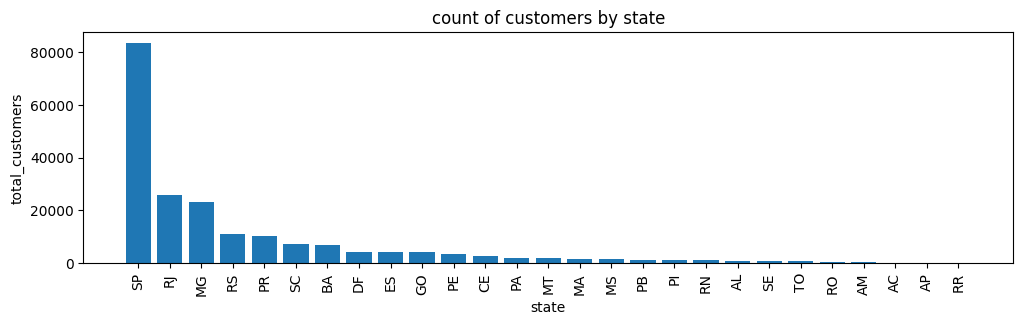

In [8]:
query = '''SELECT customer_state, count(customer_id) from customers group by customer_state'''
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns=['state', 'total_customers'])
plt.figure(figsize=(12,3))
df= df.sort_values(by= 'total_customers', ascending= False)
plt.bar(df['state'], df['total_customers'])
plt.xticks(rotation=90)
plt.xlabel("state")
plt.ylabel("total_customers")
plt.title("count of customers by state")
plt.show()

# 1. Calculate the number of orders per month in 2018.

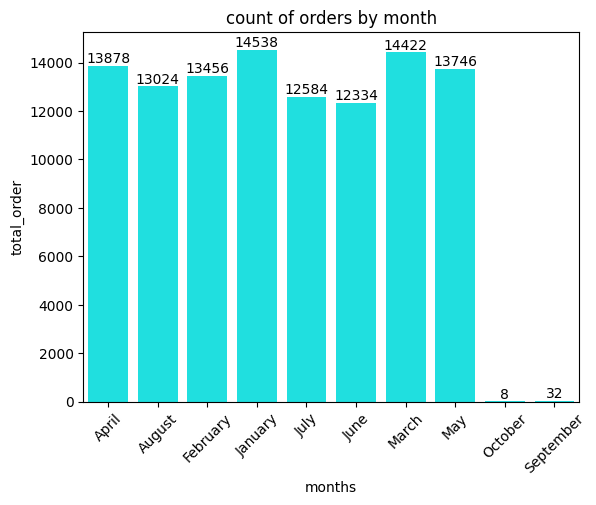

In [9]:
query = '''SELECT monthname(order_purchase_timestamp) as months, count(order_id) as total_order
from ecommerce.orders where (year(order_purchase_timestamp) = 2018) GROUP BY months
ORDER BY(months);
'''
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns=['months', 'total_order'])

# o= ["january", "fabruary","march","april","may", "june", "july","august","september","october","november","december"]
# sns.barplot(x= df["months"],y= df["total_order"], color= 'pink') # ,data = df, order= o)
ax= sns.barplot(x= df['months'],y= df['total_order'],color= 'aqua',data = df)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
# plt.figure(figsize=(18,3))
plt.title("count of orders by month")
plt.show()

#  Find the average number of products per order, grouped by customer city.

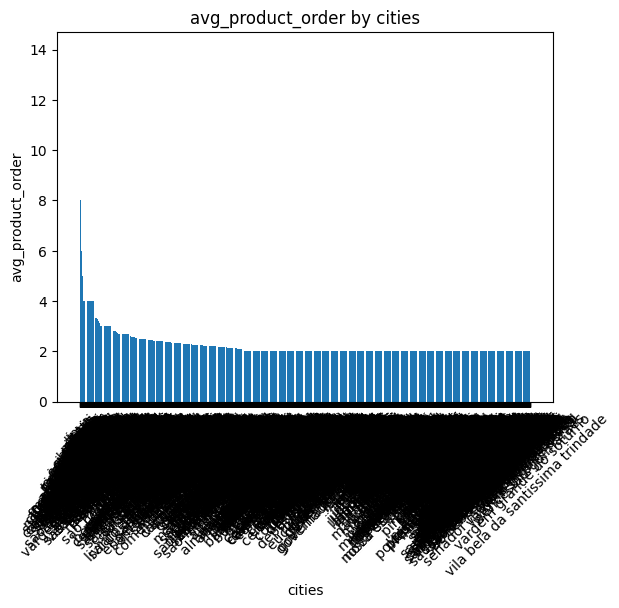

In [10]:
query = '''with count_per_order as 
(select orders.order_id, orders.customer_id, 
count(order_items.order_id) as oc from orders
join order_items ON orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) as average_orders  from customers
join count_per_order ON customers.customer_id = count_per_order.customer_id
group by  customers.customer_city order by average_orders desc
'''
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data, columns=['cities', 'avg_product_order'])
# plt.figure(figsize=(4,3))
# df= df.sort_values(by= 'avg_product_order', ascending= False)
plt.bar(df['cities'], df['avg_product_order'])
plt.xticks(rotation=90)
plt.xlabel("cities")
plt.ylabel("avg_product_order")
plt.title("avg_product_order by cities")
plt.xticks(rotation= 45)
plt.show()

# Calculate the percentage of total revenue contributed by each product category.

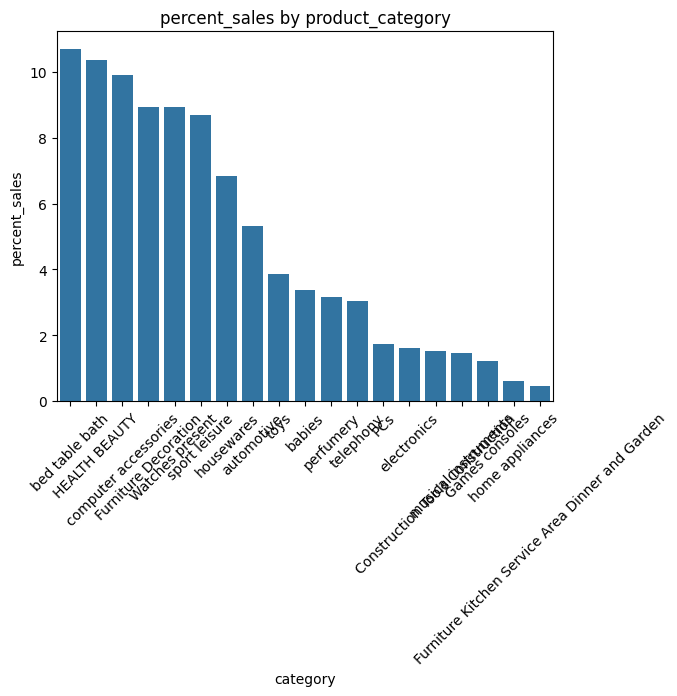

In [11]:
query = '''SELECT products.product_category AS category,
(SUM(payments.payment_value)/ (select sum(payment_value) from payments))*100 AS percent_sales
FROM products 
LEFT JOIN order_items ON products.product_id = order_items.product_id
LEFT JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products.product_category
limit 20;
'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['category', 'percent_sales'])

# plt.figure(figsize=(9,9))
df= df.sort_values(by= 'percent_sales', ascending= False)
sns.barplot(x=df['category'], y=df['percent_sales'])

plt.xticks(rotation=45)
plt.xlabel("category")
plt.ylabel("percent_sales")
plt.title("percent_sales by product_category")
plt.show()

#  Identify the correlation between product price and the number of times a product has been purchased.

In [12]:
query = '''SELECT products.product_id AS pid,
count(order_items.product_id) as ord_pv, round(avg(order_items.price),2)
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
GROUP BY products.product_id limit 5;'''

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns=['product_category','order_count', 'avg_price'])
print('df', df)
arr1 = df['order_count']
arr2 = df['avg_price']

a= np.corrcoef([arr1,arr2])
print('correlation is', a[0][-1])


df                    product_category  order_count  avg_price
0  00066f42aeeb9f3007548bb9d3f33c38            1     101.65
1  00088930e925c41fd95ebfe695fd2655            1     129.90
2  0009406fd7479715e4bef61dd91f2462            1     229.00
3  000b8f95fcb9e0096488278317764d19            2      58.90
4  000d9be29b5207b54e86aa1b1ac54872            1     199.00
correlation is -0.6791443926912982


# Calculate the total revenue generated by each seller, and rank them by revenue.

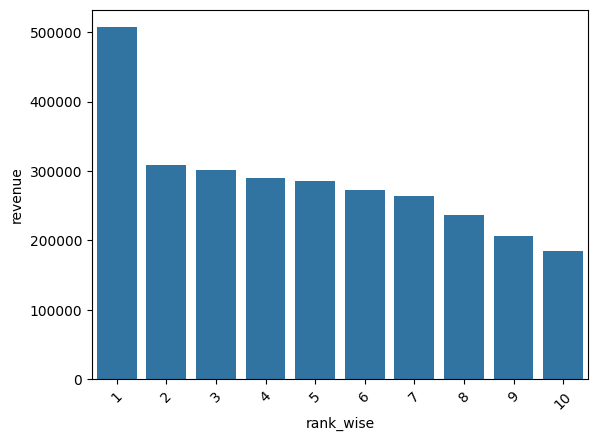

In [13]:
query = '''
SELECT order_items.seller_id AS seller,
ROUND(SUM(payments.payment_value), 2) AS revenue,
RANK() OVER (ORDER BY SUM(payments.payment_value) DESC) AS rank_wise
FROM order_items
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY order_items.seller_id LIMIT 10;
'''
cur.execute(query)
data = cur.fetchall()

# Convert to DataFrame
df = pd.DataFrame(data, columns=['seller', 'revenue', 'rank_wise'])
sns.barplot(x= 'rank_wise', y = 'revenue', data = df)
plt.xticks(rotation = 45)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [14]:
query = '''
 select customer_id, order_purchase_timestamp, payment,  avg(payment) over (partition by customer_id order by order_purchase_timestamp
 rows between 2 preceding and current row) as mov_avg
 from 
(SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment from orders
join payments on payments.order_id = orders.order_id) as a;
'''
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns= ['customer', ' ord_purch_time', 'payment', 'mov_avg'])
df

,customer,ord_purch_time,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [15]:
query = '''
select years, months, payment, sum(payment)
over(order by years, months) as cumulative_sales from 

(select year(orders.order_purchase_timestamp) as years, month(orders.order_purchase_timestamp) as months, round(sum(payments.payment_value),2) as payment
from orders join payments on payments.order_id = orders.order_id
group by years, months order by years,months) as a;
'''
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns= ['year', 'month', 'payment', 'cumulative-sales'])
df

,year,month,payment,cumulative-sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


# Calculate the year-over-year growth rate of total sales.

In [16]:
query = '''
with a as(SELECT year(orders.order_purchase_timestamp) as years, round(sum(payments.payment_value),2) as payment from orders
join payments on payments.order_id = orders.order_id
group by years order by years desc)

select years, ((payment - lag(payment, 1) over (order by years)) /  (lag(payment, 1) over (order by years)))* 100 from a;
'''
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ['years','yoy growth_rate'])
df

,years,yoy growth_rate
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [17]:
query = '''with a as(SELECT customers.customer_id, min(month(order_purchase_timestamp)) as first_order from customers
join orders on orders.customer_id = customers.customer_id 
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) as secoand_order from a
join orders on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)
select 100* (count(distinct a.customer_id)/ count(distinct b.customer_id)) from a 
left join b on a.customer_id = b.customer_id;'''

cur.execute(query)
data = cur.fetchall()
data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

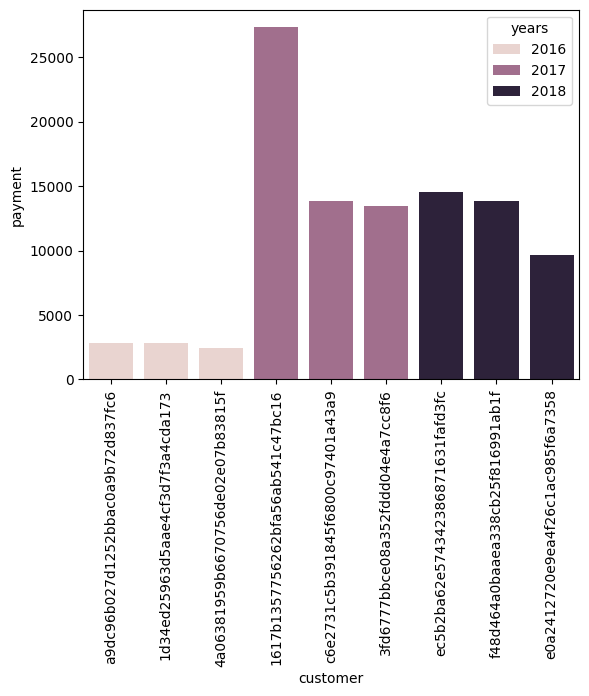

In [28]:
query = '''select years, customer_id,payment, d_rank from 
(SELECT year(orders.order_purchase_timestamp) as years, orders.customer_id, sum(payments.payment_value) as payment, 
dense_rank()over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) as d_rank FROM orders
join payments on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <= 3;'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ['years', 'customer','payment', 'rank'])
sns.barplot(x= 'customer', y= 'payment', data = df, hue = 'years')
plt.xticks(rotation = 90)
plt.show()